# League of legend dataset preprocessing

Here is the progress of data preprocessing:

1. distinguish continuous numeric, discrete numeric, categorical columns
2. filling missing value by IterativeImputer, with method decision tree. (if there is numerical missing value, use other method)
3. onehog encoder for unique value <=20, label encoder for 20-50, grouping when > 50
4. visualize columns with unique values > 50, then choose binning methods
5. normalize numerical data with big values
6. check skewness for each column(if in range(-0.5,0.5))

Next step: consider to use standard scaler or not. Do more data exploration (correlation, clustering). Feature selection (forward&backward, PCA, ensemble learning methods, such as selectKbest in sklearn)

data_nomissing.csv is the dataset just after filling missing values, data_cleaned is the dataset after data preprocessing

In [48]:
# import packages

import numpy as np
import pandas as pd
from pandas import value_counts
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeClassifier

In [49]:
data = pd.read_csv('data.csv')

In [50]:
data.head()

,team_one_win,duration,type,team_one_barons,team_two_barons,team_one_dragons,team_two_dragons,team_one_rift_heralds,team_two_rift_heralds,team_one_first_baron,...,team_two_mid_champ,team_two_bot_champ,team_two_top_champ_diff,team_two_jungle_champ_diff,team_two_mid_champ_diff,team_two_bot_champ_diff,team_two_top_champ_type,team_two_jungle_champ_type,team_two_mid_champ_type,team_two_bot_champ_type
0,0,2766,CLASSIC,0,2,2,4,0,0,0,...,Syndra,Velkoz,5,5,8,8,Tank,Fighter,Mage,Mage
1,0,1995,CLASSIC,0,1,4,1,2,0,0,...,Kassadin,Neeko,2,8,8,5,Fighter,Fighter,Assassin,Mage
2,1,1508,CLASSIC,0,0,3,0,2,0,0,...,Viktor,Thresh,9,7,9,7,Fighter,Fighter,Mage,Support
3,1,1222,CLASSIC,0,0,2,0,0,0,0,...,TwistedFate,Pyke,7,4,9,7,Fighter,Assassin,Mage,Support
4,0,1808,CLASSIC,0,1,1,3,1,1,0,...,Ryze,Tristana,6,8,7,4,Fighter,Tank,Mage,Marksman


In [51]:
data.shape

(12201, 79)

In [52]:
# continuous numeric column
data_continuous = data.select_dtypes(include=[np.float])

# this include all float columns, but some columns like duration does not included.
data_numbers = data.select_dtypes(include=[np.number], exclude = [np.float])

unique = pd.DataFrame(data_numbers.nunique())
continuous_list = unique.index[unique[0] > 50].tolist() # when unique values > 50, consider as continous variable, such as duration is the total time for the game
discrete_numeric_list = unique.index[unique[0] <= 50].tolist()

In [53]:
# final decision for continuous numeric column
data_continuous_numeric = pd.concat([data_continuous, data[continuous_list]], axis = 1)

# final decision for discrete numeric column
data_discrete_numeric = data[discrete_numeric_list]

In [54]:
# categorical columns
data_non_numeric = data.select_dtypes(exclude=[np.number])
data_non_numeric_col = data.select_dtypes(exclude=[np.number]).columns.tolist()
data_non_numeric_col

['type',
 'team_one_top_champ',
 'team_one_jungle_champ',
 'team_one_mid_champ',
 'team_one_bot_champ',
 'team_one_top_champ_type',
 'team_one_jungle_champ_type',
 'team_one_mid_champ_type',
 'team_one_bot_champ_type',
 'team_two_top_champ',
 'team_two_jungle_champ',
 'team_two_mid_champ',
 'team_two_bot_champ',
 'team_two_top_champ_type',
 'team_two_jungle_champ_type',
 'team_two_mid_champ_type',
 'team_two_bot_champ_type']

In [55]:
data_non_numeric.head()

,type,team_one_top_champ,team_one_jungle_champ,team_one_mid_champ,team_one_bot_champ,team_one_top_champ_type,team_one_jungle_champ_type,team_one_mid_champ_type,team_one_bot_champ_type,team_two_top_champ,team_two_jungle_champ,team_two_mid_champ,team_two_bot_champ,team_two_top_champ_type,team_two_jungle_champ_type,team_two_mid_champ_type,team_two_bot_champ_type
0,CLASSIC,Quinn,Evelynn,TwistedFate,Senna,Marksman,Assassin,Mage,Marksman,Chogath,Skarner,Syndra,Velkoz,Tank,Fighter,Mage,Mage
1,CLASSIC,Singed,LeeSin,Syndra,Jhin,Tank,Fighter,Mage,Marksman,XinZhao,Kayn,Kassadin,Neeko,Fighter,Fighter,Assassin,Mage
2,CLASSIC,Urgot,MonkeyKing,Malzahar,Ezreal,Fighter,Fighter,Mage,Marksman,Gangplank,Udyr,Viktor,Thresh,Fighter,Fighter,Mage,Support
3,CLASSIC,NaN,Fiora,Neeko,Thresh,NaN,Fighter,Mage,Support,Kled,MasterYi,TwistedFate,Pyke,Fighter,Assassin,Mage,Support
4,CLASSIC,Garen,Rengar,Yone,Lulu,Fighter,Assassin,Assassin,Support,Nasus,Zac,Ryze,Tristana,Fighter,Tank,Mage,Marksman


Looks like there is no strange text words. Now, filling missing values depends on different type of words

In [56]:
missing_value = data.isnull().sum().sort_values(ascending = False)
missing_value_list = missing_value.index.where(missing_value > 0).dropna().tolist()
missing_value[:20]

team_one_top_champ            2521
team_one_top_champ_type       2521
team_two_top_champ_type       2309
team_two_top_champ            2309
team_one_bot_champ            1757
team_one_bot_champ_type       1757
team_one_mid_champ            1741
team_one_mid_champ_type       1741
team_two_mid_champ_type       1689
team_two_mid_champ            1689
team_two_jungle_champ_type    1283
team_two_jungle_champ         1283
team_one_jungle_champ_type    1223
team_one_jungle_champ         1223
team_two_bot_champ_type       1195
team_two_bot_champ            1195
team_one_dragons                 0
team_one_damage                  0
team_two_double_kills            0
team_one_double_kills            0
dtype: int64

it looks like there is 10+ columns has missing values, the missing value is about 10% to 20% of these column

In [57]:
data[missing_value_list].head()

,team_one_top_champ,team_one_top_champ_type,team_two_top_champ_type,team_two_top_champ,team_one_bot_champ,team_one_bot_champ_type,team_one_mid_champ,team_one_mid_champ_type,team_two_mid_champ_type,team_two_mid_champ,team_two_jungle_champ_type,team_two_jungle_champ,team_one_jungle_champ_type,team_one_jungle_champ,team_two_bot_champ_type,team_two_bot_champ
0,Quinn,Marksman,Tank,Chogath,Senna,Marksman,TwistedFate,Mage,Mage,Syndra,Fighter,Skarner,Assassin,Evelynn,Mage,Velkoz
1,Singed,Tank,Fighter,XinZhao,Jhin,Marksman,Syndra,Mage,Assassin,Kassadin,Fighter,Kayn,Fighter,LeeSin,Mage,Neeko
2,Urgot,Fighter,Fighter,Gangplank,Ezreal,Marksman,Malzahar,Mage,Mage,Viktor,Fighter,Udyr,Fighter,MonkeyKing,Support,Thresh
3,NaN,NaN,Fighter,Kled,Thresh,Support,Neeko,Mage,Mage,TwistedFate,Assassin,MasterYi,Fighter,Fiora,Support,Pyke
4,Garen,Fighter,Fighter,Nasus,Lulu,Support,Yone,Assassin,Mage,Ryze,Tank,Zac,Assassin,Rengar,Marksman,Tristana


All of them are categorical data. Look at how many unique values they have

In [58]:
data[missing_value_list].nunique()

team_one_top_champ            152
team_one_top_champ_type         6
team_two_top_champ_type         6
team_two_top_champ            151
team_one_bot_champ            136
team_one_bot_champ_type         6
team_one_mid_champ            148
team_one_mid_champ_type         6
team_two_mid_champ_type         6
team_two_mid_champ            149
team_two_jungle_champ_type      6
team_two_jungle_champ         148
team_one_jungle_champ_type      6
team_one_jungle_champ         143
team_two_bot_champ_type         6
team_two_bot_champ            133
dtype: int64

Since each game are independent than others, we cannot fill values with nearby values. I want to use IterativeImputer, a strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion.

https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer

In [59]:
imp_mode = IterativeImputer(random_state=0, estimator = DecisionTreeClassifier(), initial_strategy = "most_frequent" )
filled_value = imp_mode.fit_transform(data[missing_value_list].apply(LabelEncoder().fit_transform))
data[missing_value_list] = filled_value

In [60]:
data.isnull().sum().sort_values(ascending = False)

team_two_bot_champ_type     0
team_two_double_kills       0
team_one_obj_damage         0
team_two_obj_damage         0
team_one_deaths             0
                           ..
team_one_mid_avg_xp_diff    0
team_one_bot_avg_xp_diff    0
team_one_top_champ          0
team_one_jungle_champ       0
team_one_win                0
Length: 79, dtype: int64

Now filled the missing values

In [61]:
# save data
data.to_csv("data_nomissing.csv", index=False)


Then label encoding the data, depends on number of unique values

In [62]:
data[discrete_numeric_list + data_non_numeric_col].nunique()

team_one_win                    2
team_one_barons                 5
team_two_barons                 5
team_one_dragons                8
team_two_dragons                7
team_one_rift_heralds           3
team_two_rift_heralds           3
team_one_first_baron            2
team_one_first_blood            2
team_one_first_dragon           2
team_one_first_inhibitor        2
team_one_first_rift_herald      2
team_one_first_tower            2
team_one_double_kills          18
team_two_double_kills          13
team_one_top_champ_diff        11
team_one_jungle_champ_diff     11
team_one_mid_champ_diff        11
team_one_bot_champ_diff        11
team_two_top_champ_diff        11
team_two_jungle_champ_diff     11
team_two_mid_champ_diff        11
team_two_bot_champ_diff        11
type                            1
team_one_top_champ            153
team_one_jungle_champ         144
team_one_mid_champ            149
team_one_bot_champ            137
team_one_top_champ_type         7
team_one_jungl

if unique value is <= 20: use one-hog encoder

elif unique value is <= 50: use encoder

In [63]:
discrete_colname = discrete_numeric_list + data_non_numeric_col
data_discrete = data[discrete_numeric_list + data_non_numeric_col]
unique = pd.DataFrame(data_non_numeric.nunique())

# when unique vlaue > 50, grouping them later
unique_grouping = unique.index[unique[0] > 50].tolist()

# when unique value > 20 and <= 50, use simple encoder
unique_le = unique.index[(unique[0] > 20) & (unique[0] <= 50)].tolist()

# when unique value <= 20, use onehog encoder
unique_onehog = unique.index[unique[0] <= 20].tolist()

One hog encoder in sklearn for dummy variables (when unique observation < 20 in each column)

In [64]:
data_onehog = data[unique_onehog]
data_onehog.head()

,type,team_one_top_champ_type,team_one_jungle_champ_type,team_one_mid_champ_type,team_one_bot_champ_type,team_two_top_champ_type,team_two_jungle_champ_type,team_two_mid_champ_type,team_two_bot_champ_type
0,CLASSIC,3.0,0.0,2.0,3.0,5.0,1.0,2.0,2.0
1,CLASSIC,5.0,1.0,2.0,3.0,1.0,1.0,0.0,2.0
2,CLASSIC,1.0,1.0,2.0,3.0,1.0,1.0,2.0,4.0
3,CLASSIC,6.0,1.0,2.0,4.0,1.0,0.0,2.0,4.0
4,CLASSIC,1.0,0.0,0.0,4.0,1.0,5.0,2.0,3.0


In [65]:
onehog = OneHotEncoder()
onehog_solution = onehog.fit_transform(data_onehog).toarray()
ohe_df = pd.DataFrame(onehog_solution, columns=onehog.get_feature_names(data_onehog.columns))
ohe_df.head()

,type_CLASSIC,team_one_top_champ_type_0.0,team_one_top_champ_type_1.0,team_one_top_champ_type_2.0,team_one_top_champ_type_3.0,team_one_top_champ_type_4.0,team_one_top_champ_type_5.0,team_one_top_champ_type_6.0,team_one_jungle_champ_type_0.0,team_one_jungle_champ_type_1.0,...,team_two_mid_champ_type_4.0,team_two_mid_champ_type_5.0,team_two_mid_champ_type_6.0,team_two_bot_champ_type_0.0,team_two_bot_champ_type_1.0,team_two_bot_champ_type_2.0,team_two_bot_champ_type_3.0,team_two_bot_champ_type_4.0,team_two_bot_champ_type_5.0,team_two_bot_champ_type_6.0
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [66]:
le = LabelEncoder()
data_le = data[unique_le]
le_df = data_le.apply(LabelEncoder().fit_transform)
le_df

Series([], dtype: float64)

I found that there is no discrete numeric or categorical columns has unique values between 20-50.

In [67]:
# we need to grouping for columns in unique_grouping

In [68]:
data_cleaned = pd.concat([data, ohe_df], axis = 1)
data_cleaned.drop(columns=unique_onehog, inplace = True)
#data_cleaned.drop(columns=unique_le, inplace = True) # unique_le is empty
data_cleaned

,team_one_win,duration,team_one_barons,team_two_barons,team_one_dragons,team_two_dragons,team_one_rift_heralds,team_two_rift_heralds,team_one_first_baron,team_one_first_blood,...,team_two_mid_champ_type_4.0,team_two_mid_champ_type_5.0,team_two_mid_champ_type_6.0,team_two_bot_champ_type_0.0,team_two_bot_champ_type_1.0,team_two_bot_champ_type_2.0,team_two_bot_champ_type_3.0,team_two_bot_champ_type_4.0,team_two_bot_champ_type_5.0,team_two_bot_champ_type_6.0
0,0,2766,0,2,2,4,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,1995,0,1,4,1,2,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,1508,0,0,3,0,2,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,1222,0,0,2,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,1808,0,1,1,3,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12196,1,1729,1,0,4,0,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12197,0,790,0,0,0,0,0,1,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12198,0,1153,0,0,2,1,1,1,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12199,1,1075,0,0,2,0,2,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Binning columns in unique_grouping. Since there is many unique values, one possible way is binning by frequency. draw histogram

Since the values are independent with each other, since they just represent different categorical value. The value itself means nothing, so, I can sort them by occurance.

In [69]:
data_cleaned[unique_grouping]

,team_one_top_champ,team_one_jungle_champ,team_one_mid_champ,team_one_bot_champ,team_two_top_champ,team_two_jungle_champ,team_two_mid_champ,team_two_bot_champ
0,90.0,23.0,122.0,91.0,18.0,109.0,112.0,116.0
1,108.0,58.0,112.0,40.0,140.0,54.0,51.0,71.0
2,129.0,70.0,67.0,23.0,31.0,126.0,132.0,107.0
3,152.0,26.0,77.0,110.0,58.0,70.0,122.0,79.0
4,32.0,91.0,139.0,58.0,76.0,143.0,96.0,108.0
...,...,...,...,...,...,...,...,...
12196,6.0,77.0,66.0,117.0,135.0,25.0,140.0,64.0
12197,152.0,143.0,148.0,136.0,151.0,148.0,149.0,133.0
12198,152.0,143.0,148.0,136.0,151.0,148.0,149.0,133.0
12199,152.0,143.0,148.0,136.0,151.0,148.0,149.0,133.0


In [70]:
data_cleaned[unique_grouping].iloc[:,1].value_counts(ascending=True)

39.0        1
89.0        1
80.0        1
1.0         1
11.0        1
         ... 
126.0     479
51.0      548
53.0      548
34.0      677
143.0    1223
Name: team_one_jungle_champ, Length: 144, dtype: int64

In [71]:
for j in range(len(unique_grouping)):
    test_keys = data_cleaned[unique_grouping].iloc[:,j].value_counts(ascending=True).index.tolist()
    test_values = range(len(test_keys))
    res = {data_cleaned[unique_grouping].columns[j]:{test_keys[i]: test_values[i] for i in range(len(test_keys))}}
    data_cleaned.replace(res, inplace = True)
    

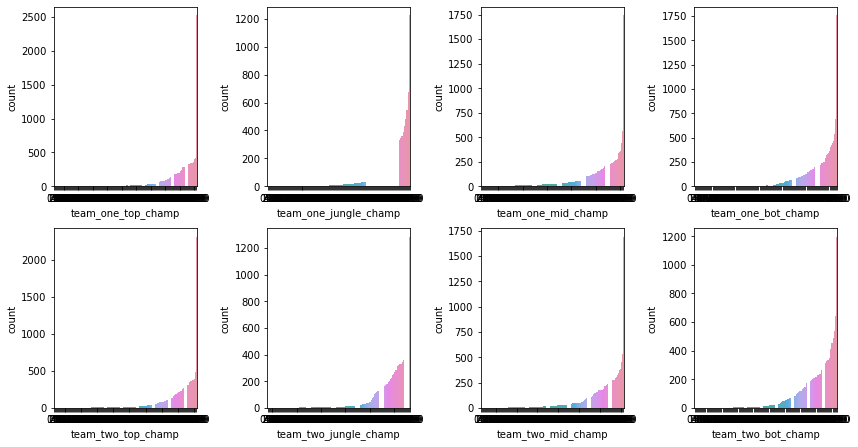

In [72]:
fig = plt.figure(figsize=(12,12))
for index,col in enumerate(unique_grouping):
    plt.subplot(4,4,index+1)
    sns.countplot(data_cleaned[unique_grouping].loc[:,col].dropna())
fig.tight_layout(pad=1.0)

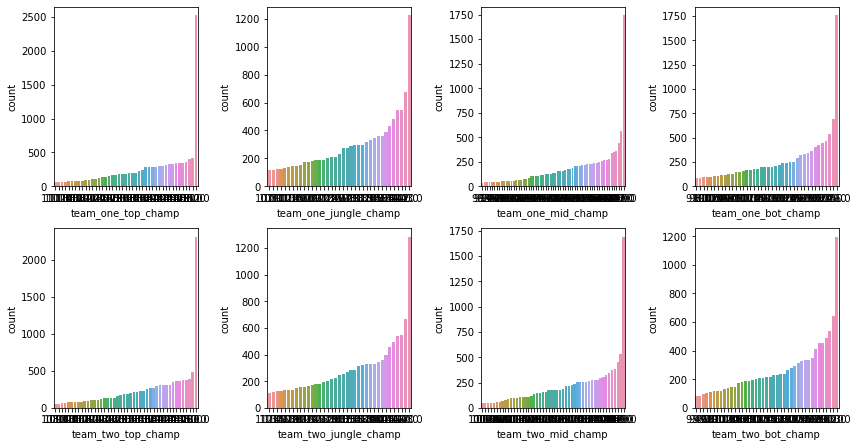

In [83]:
# delete lower 10% percentile for each column

fig = plt.figure(figsize=(12,12))
for index,col in enumerate(unique_grouping):
    plt.subplot(4,4,index+1)
    sns.countplot(data_cleaned[unique_grouping].loc[:,col][data_cleaned[col] > data_cleaned[col].quantile(.1)])
fig.tight_layout(pad=1.0)

In [74]:
data_group = data_cleaned[unique_grouping]
data_group

,team_one_top_champ,team_one_jungle_champ,team_one_mid_champ,team_one_bot_champ,team_two_top_champ,team_two_jungle_champ,team_two_mid_champ,team_two_bot_champ
0,114.0,127.0,142.0,133.0,146.0,128.0,125.0,86.0
1,130.0,134.0,122.0,134.0,73.0,145.0,140.0,75.0
2,142.0,101.0,132.0,132.0,133.0,142.0,143.0,130.0
3,152.0,82.0,116.0,131.0,119.0,136.0,142.0,112.0
4,151.0,124.0,147.0,125.0,142.0,114.0,126.0,127.0
...,...,...,...,...,...,...,...,...
12196,90.0,130.0,98.0,126.0,115.0,130.0,148.0,118.0
12197,152.0,143.0,148.0,136.0,151.0,148.0,149.0,133.0
12198,152.0,143.0,148.0,136.0,151.0,148.0,149.0,133.0
12199,152.0,143.0,148.0,136.0,151.0,148.0,149.0,133.0


The distributions shows what I want to do, sort the value by frequency.Then binning them by qcut

By the histograms, 

In [28]:
for colname in unique_grouping:
    data_cleaned[colname] = pd.qcut(data_cleaned[colname], q=7, duplicates = 'drop')

In [29]:
data_cleaned[unique_grouping].head()

,team_one_top_champ,team_one_jungle_champ,team_one_mid_champ,team_one_bot_champ,team_two_top_champ,team_two_jungle_champ,team_two_mid_champ,team_two_bot_champ
0,"(-0.001, 117.0]","(121.0, 128.0]","(137.0, 143.0]","(132.0, 136.0]","(143.0, 148.0]","(126.0, 134.0]","(123.0, 132.0]","(-0.001, 98.0]"
1,"(117.0, 130.0]","(128.0, 134.0]","(119.0, 129.0]","(132.0, 136.0]","(-0.001, 114.0]","(144.0, 147.0]","(139.0, 144.0]","(-0.001, 98.0]"
2,"(138.0, 144.0]","(-0.001, 110.0]","(129.0, 137.0]","(128.0, 132.0]","(129.0, 137.0]","(139.0, 144.0]","(139.0, 144.0]","(128.0, 132.0]"
3,"(149.0, 152.0]","(-0.001, 110.0]","(101.0, 119.0]","(128.0, 132.0]","(114.0, 129.0]","(134.0, 139.0]","(139.0, 144.0]","(109.0, 117.0]"
4,"(149.0, 152.0]","(121.0, 128.0]","(143.0, 147.0]","(122.0, 128.0]","(137.0, 143.0]","(-0.001, 115.0]","(123.0, 132.0]","(123.0, 128.0]"


In [30]:
# use onehog encoder
onehog = OneHotEncoder()
onehog_solution = onehog.fit_transform(data_cleaned[unique_grouping]).toarray()
ohe_df = pd.DataFrame(onehog_solution, columns=onehog.get_feature_names(data_cleaned[unique_grouping].columns))
ohe_df.head()


,"team_one_top_champ_(-0.001, 117.0]","team_one_top_champ_(117.0, 130.0]","team_one_top_champ_(130.0, 138.0]","team_one_top_champ_(138.0, 144.0]","team_one_top_champ_(144.0, 149.0]","team_one_top_champ_(149.0, 152.0]","team_one_jungle_champ_(-0.001, 110.0]","team_one_jungle_champ_(110.0, 121.0]","team_one_jungle_champ_(121.0, 128.0]","team_one_jungle_champ_(128.0, 134.0]",...,"team_two_mid_champ_(139.0, 144.0]","team_two_mid_champ_(144.0, 148.0]","team_two_mid_champ_(148.0, 149.0]","team_two_bot_champ_(-0.001, 98.0]","team_two_bot_champ_(98.0, 109.0]","team_two_bot_champ_(109.0, 117.0]","team_two_bot_champ_(117.0, 123.0]","team_two_bot_champ_(123.0, 128.0]","team_two_bot_champ_(128.0, 132.0]","team_two_bot_champ_(132.0, 133.0]"
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [31]:
data_cleaned = pd.concat([data_cleaned, ohe_df], axis = 1)
data_cleaned.drop(columns=unique_grouping, inplace = True)
#data_cleaned.drop(columns=unique_le, inplace = True) # unique_le is empty
data_cleaned

,team_one_win,duration,team_one_barons,team_two_barons,team_one_dragons,team_two_dragons,team_one_rift_heralds,team_two_rift_heralds,team_one_first_baron,team_one_first_blood,...,"team_two_mid_champ_(139.0, 144.0]","team_two_mid_champ_(144.0, 148.0]","team_two_mid_champ_(148.0, 149.0]","team_two_bot_champ_(-0.001, 98.0]","team_two_bot_champ_(98.0, 109.0]","team_two_bot_champ_(109.0, 117.0]","team_two_bot_champ_(117.0, 123.0]","team_two_bot_champ_(123.0, 128.0]","team_two_bot_champ_(128.0, 132.0]","team_two_bot_champ_(132.0, 133.0]"
0,0,2766,0,2,2,4,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1995,0,1,4,1,2,0,0,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1508,0,0,3,0,2,0,0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,1222,0,0,2,0,0,0,0,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,1808,0,1,1,3,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12196,1,1729,1,0,4,0,0,0,1,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12197,0,790,0,0,0,0,0,1,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12198,0,1153,0,0,2,1,1,1,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12199,1,1075,0,0,2,0,2,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Now finishing the binning. Then normalize continuous numerical data with big values by min max scaler

In [32]:
data_cleaned[continuous_list].head()

,duration,team_one_assists,team_two_assists,team_one_level,team_two_level,team_one_kills,team_two_kills,team_one_obj_damage,team_two_obj_damage,team_one_deaths,...,team_one_cc_time,team_two_cc_time,team_one_healing,team_two_healing,team_one_champ_damage,team_two_champ_damage,team_one_cs,team_two_cs,team_one_vision_score,team_two_vision_score
0,2766,83,79,89,90,55,60,33224,90409,60,...,264,227,51002,61620,206577,168252,708,635,180,230
1,1995,14,36,74,83,17,30,66819,54606,30,...,116,103,26401,56479,76829,95328,570,714,116,152
2,1508,44,22,61,59,34,15,76951,9927,15,...,97,102,22529,18306,69919,47464,386,475,143,87
3,1222,35,13,55,50,34,16,21731,12317,16,...,65,53,17822,7525,58777,39427,343,308,77,52
4,1808,28,43,71,76,14,21,35925,94585,21,...,97,92,34748,43223,63270,67622,719,641,104,137


In [33]:
minmax_scaler = MinMaxScaler()
minmax_sol = minmax_scaler.fit_transform(data_cleaned[continuous_list])
minmax_df = pd.DataFrame(minmax_sol, columns=continuous_list)
minmax_df.head()

,duration,team_one_assists,team_two_assists,team_one_level,team_two_level,team_one_kills,team_two_kills,team_one_obj_damage,team_two_obj_damage,team_one_deaths,...,team_one_cc_time,team_two_cc_time,team_one_healing,team_two_healing,team_one_champ_damage,team_two_champ_damage,team_one_cs,team_two_cs,team_one_vision_score,team_two_vision_score
0,0.758468,0.588652,0.556338,0.987654,1.000000,0.597826,0.740741,0.198563,0.582378,0.740741,...,0.488889,0.453094,0.384546,0.403654,0.799217,0.526393,0.606272,0.460517,0.388769,0.598958
1,0.531370,0.099291,0.253521,0.802469,0.914634,0.184783,0.370370,0.399344,0.351750,0.370370,...,0.214815,0.205589,0.198796,0.369926,0.296044,0.297805,0.486063,0.518819,0.250540,0.395833
2,0.387923,0.312057,0.154930,0.641975,0.621951,0.369565,0.185185,0.459898,0.063946,0.185185,...,0.179630,0.203593,0.169561,0.119488,0.269247,0.147769,0.325784,0.342435,0.308855,0.226562
3,0.303682,0.248227,0.091549,0.567901,0.512195,0.369565,0.197531,0.129875,0.079341,0.197531,...,0.120370,0.105788,0.134021,0.048758,0.226037,0.122576,0.288328,0.219188,0.166307,0.135417
4,0.476289,0.198582,0.302817,0.765432,0.829268,0.152174,0.259259,0.214706,0.609278,0.259259,...,0.179630,0.183633,0.261820,0.282959,0.243462,0.210957,0.615854,0.464945,0.224622,0.356771


In [34]:
data_cleaned[continuous_list] = minmax_df

data_cleaned

,team_one_win,duration,team_one_barons,team_two_barons,team_one_dragons,team_two_dragons,team_one_rift_heralds,team_two_rift_heralds,team_one_first_baron,team_one_first_blood,...,"team_two_mid_champ_(139.0, 144.0]","team_two_mid_champ_(144.0, 148.0]","team_two_mid_champ_(148.0, 149.0]","team_two_bot_champ_(-0.001, 98.0]","team_two_bot_champ_(98.0, 109.0]","team_two_bot_champ_(109.0, 117.0]","team_two_bot_champ_(117.0, 123.0]","team_two_bot_champ_(123.0, 128.0]","team_two_bot_champ_(128.0, 132.0]","team_two_bot_champ_(132.0, 133.0]"
0,0,0.758468,0,2,2,4,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.531370,0,1,4,1,2,0,0,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.387923,0,0,3,0,2,0,0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,0.303682,0,0,2,0,0,0,0,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,0.476289,0,1,1,3,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12196,1,0.453019,1,0,4,0,0,0,1,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12197,0,0.176436,0,0,0,0,0,1,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12198,0,0.283358,0,0,2,1,1,1,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12199,1,0.260383,0,0,2,0,2,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [35]:
skew_series = data_cleaned.skew(axis = 0).sort_values(ascending = False)
skew_series

team_one_top_champ_type_4.0    10.693644
team_two_bot_champ_type_0.0    10.390083
team_two_top_champ_type_4.0    10.201046
team_two_mid_champ_type_4.0     9.571552
team_one_bot_champ_type_0.0     9.107947
                                 ...    
team_two_bot_champ_diff        -0.592151
team_one_mid_champ_diff        -0.722853
team_two_mid_champ_diff        -0.757182
team_two_level                 -0.960506
team_one_level                 -0.987277
Length: 172, dtype: float64

advantage & disadvantage for scaler, normalizer

https://stackoverflow.com/questions/51841506/data-standardization-vs-normalization-vs-robust-scaler

How to do classification after clustering?

https://stats.stackexchange.com/questions/264312/how-to-do-classification-after-clustering
    

In [37]:
data_cleaned.to_csv("data_cleaned.csv", index=False)